<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**


*Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.*

*Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tags pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.*



**Solutions mises en oeuvre**

Les solutions de suggestion de tags présentés ici se basent sur des modèles *non-supervisés* de machine learning.

Les modèles mis en oeuvre : 
    * Clusterisation par K-means
    * LDA
    * Word2Vec
    * Gloves

Ce notebook utilise les données issues du notebook **P6_DadaAnalysis.ipynb**



In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import p6_util
import p6_util_plot

In [ ]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
df_sof_tags.shape

In [ ]:
df_sof_tags.columns

In [ ]:
list_sof_tags = df_sof_tags.TagName.tolist()

# <font color='blus'>3. Unsupervised methods</font>

TAGS are regarded as keywords.

Aims of this section is to create data points then identify clusters from this set of data.

These data-points are digital representation of the cleaned documents dataset.

For each-one of the clusters, most representative terms will be identified.

These terms will be considered as TAGs.

Differents embeddings techniques will be used in order to create data-points : 

* Bag of words
* Co-occurence
* TF-IDF

**Loading train dataset and extract users questions from Body column**

In [ ]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)
print(df_sof_train.shape)

In [ ]:
type(df_sof_train['Body'])

**Standardize `Body` column from dataset**

In [ ]:
import p6_util
ser_document_std = p6_util.p6_df_standardization(df_sof_train['Body'],is_stemming=False, is_lem=False)

**Save dataframe with standardized `Body` column**

In [ ]:
import p5_util
file_name="./data/df_document_std.dump"
p5_util.object_dump(ser_document_std, file_name)

**Load standardized corpus**

In [ ]:
import p5_util
file_name="./data/ser_sof_train.dump"
ser_sof_train = p5_util.object_load(file_name)
print(ser_sof_train.shape)

In [ ]:
ser_document_std = ser_sof_train[:16359]
print(ser_document_std.shape)

#### Corpus vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# When building vacabulary, terms with frequency document < p_min_df are ignored.
p_min_df = 0.0005
# When building vacabulary, terms with frequency document> p_max_df are ignored.
p_max_df = 1.


dict_sof_document = ser_document_std.to_dict()

ngram1=1
ngram2=1
vectorizer=TfidfVectorizer(norm="l2", use_idf=True, min_df=p_min_df, max_df=p_max_df, ngram_range=(ngram1, ngram2))

csr_matrix = vectorizer.fit_transform(dict_sof_document.values())

print(csr_matrix.shape)

**Save vectorization with ngram (2,2) mode**

In [ ]:
import p5_util
file_name="./data/csr_matrix_tfidf_1gram.dump"
p5_util.object_dump(csr_matrix, file_name)

file_name="./data/vectorizer_tfidf_1gram.dump"
p5_util.object_dump(vectorizer, file_name)

## <font color='blus'>3.1 Kmeans clustering</font>

**Load vectorization operator and CSR matrix**

In [ ]:
import p5_util
file_name="./data/csr_matrix_tfidf_1gram.dump"
csr_matrix  = p5_util.object_load(file_name)

file_name="./data/vectorizer_tfidf_1gram.dump"
vectorizer = p5_util.object_load(file_name)

In [ ]:
#type(csr_matrix) is a 'csr_matrix'
print(type(csr_matrix))
if isinstance(csr_matrix, 'scipy.sparse.csr.csr_matrix') :
    print("YES")
else :
    print("NO")

In [ ]:
import p5_util
cluster_start = 1
cluster_end = 10
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_customers, cluster_start, cluster_end)

**Proceed to Kmeans clustering**

In [ ]:
from sklearn.cluster import KMeans
n_cluster=100
cluster_kmean=KMeans(n_clusters=n_cluster).fit(csr_matrix)

print(len(cluster_kmean.labels_))

**Save Kmeans clustering**

In [ ]:
file_name="./data/cluster_kmeans_labels_100.dump"
p5_util.object_dump(cluster_kmean.labels_, file_name)

**For each cluster build a TAG list**

In [ ]:
file_name="./data/cluster_kmeans_labels_100.dump"
cluster_kmean_labels = p5_util.object_load(file_name)

In [ ]:
import p6_util
p_tag_ratio=1.0
dict_list_cluster_tag, dict_cluster_stat, dict_df_freq_cluster_tag \
= p6_util.get_dict_list_cluster_tag(cluster_kmean_labels, dict_sof_document, vectorizer, p_tag_ratio)

In [ ]:
import p5_util
file_name="./data/dict_list_cluster_tag.dump"
p5_util.object_dump(dict_list_cluster_tag, file_name)

#### Plot cluster distribution

In [ ]:
import pandas as pd
# Convert dictionary as dataframe allowing having statisticals values
df_cluster_stat = pd.DataFrame.from_dict(dict_cluster_stat, orient='index')
df_cluster_stat.rename(columns={0:'cluster'},inplace=True)

min_cluster_count = min(df_cluster_stat.cluster)
max_cluster_count = max(df_cluster_stat.cluster)

#Get outliers clusters : mix and max values
cluster_max_id = df_cluster_stat.query("cluster == "+str(max_cluster_count), inplace=False).index[0]
cluster_min_id = df_cluster_stat.query("cluster == "+str(min_cluster_count), inplace=False).index[0]

print("Cluster {} : elements= {} ".format(cluster_min_id, min_cluster_count))
print("Cluster {} : elements= {} ".format(cluster_max_id, max_cluster_count))


**Display Questions distribution among clusters**

In [ ]:
df_cluster_stat.query("cluster <= 1000", inplace=True)
ax = df_cluster_stat.plot.bar(figsize=(7, 7), title="Questions distribution", color='orange', fontsize=14)

**Display cluster with lower number of elements**

In [ ]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_min_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

In [ ]:
print(dict_list_cluster_tag[cluster_min_id])
print("\n")
#print(dict_list_cluster_tag[cluster_max_id])

**Display cluster with greater number of elements**

In [ ]:
import p6_util_plot
df_freq_cluster_tag = dict_df_freq_cluster_tag[cluster_max_id]
dict_freq_cluster_tag = df_freq_cluster_tag.to_dict()['Freq']
p6_util_plot.display_word_cloud(dict_freq_cluster_tag)

## Testing process

Questions (Posts) are vectorized.

Vectorization leads to a Matrix.

Transpozed matrix is clusterized : transpozed matrix columns are questions (Posts).

A clustering algorythm is applied over transposed matrix. Each cluster compound a set of questions.

Each cluster is assigned with some TAGs that way : 

* In any cluster, TAGs are picked up from vectors components.

* For each one of the cluster element : 
    * Greatest components values are picked up.
    * TAGs to be assigned are vocabulary terms matching with picked-up values.


## <font color='blus'>3.3. LDA Performances evaluation with TFIDF</font>

In [1]:
import p5_util
file_name="./data/csr_matrix_tfidf_ngram1_b.dump"
csr_matrix = p5_util.object_load(file_name)

file_name="./data/vectorizer_tfidf_ngram1_b.dump"
vectorizer = p5_util.object_load(file_name)

bow_feature_names = vectorizer.get_feature_names()

embedding_type = "tfidf"

print(csr_matrix.shape)

p5_util.object_load : fileName= ./data/csr_matrix_tfidf_ngram1_b.dump
p5_util.object_load : fileName= ./data/vectorizer_tfidf_ngram1_b.dump
(24604, 6304)


### <font color='blue'>3.3.1. Building a set of LDAs models depending of numbers of topics</font>

In [3]:
import p5_util
import p6_util
range_1_topic = range(10,110,10)

p6_util.p6_lda_build_range(range_1_topic,embedding_type, csr_matrix)


Building LDA model with 10 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 20 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 30 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 40 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 50 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 60 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 70 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 80 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 90 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 100 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [4]:
import p6_util

range_2_topic = range(200,600,100)
p6_util.p6_lda_build_range(range_2_topic,embedding_type, csr_matrix)


Building LDA model with 200 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 300 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 400 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Building LDA model with 500 topics


/home/bangui/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


### <font color='blue'>3.3.2. LDA performances evaluation with TFIDF</font>

In [5]:
import pandas as pd

file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)

list_sof_tags = df_sof_tags.TagName.tolist()
nb_test = 1000

print(df_sof_tags.shape)

(50000, 2)


**<font color='blue'>Accuracy score computing for topics ranged from 10 to 100</font>**

* For each one of the LDA models ranging from 10 to 100, 1000 random POSTs will be selected from TEST dataset.

* A matching is performed between TAGs issued from POSTs and those issued from LDA model.

* Accuracy is computed from `number of matching TAGs / number of POSTs TAGs`.

* For each model ranging from 10 to 100 topics, results are stored into dictionary and saved into dumped files.


In [6]:
import p6_util

p6_util.p6_lda_range_mean_score(nb_test, range_1_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer) 

p5_util.object_load : fileName= ./data/lda_tfidf_10topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_20topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_30topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_40topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_50topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_60topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_70topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_80topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_90topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_100topics.dump


**<font color='blue'>Accuracy score computing for topics ranged from 200 to 500</font>**

In [7]:
import p6_util

p6_util.p6_lda_range_mean_score(nb_test, range_2_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer) 

p5_util.object_load : fileName= ./data/lda_tfidf_200topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_300topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_400topics.dump
p5_util.object_load : fileName= ./data/lda_tfidf_500topics.dump


In [8]:
import numpy as np

if str(embedding_type) == 'bow' :
    dict_lda_bow_mean_accuracy = dict()
elif str(embedding_type) == 'tfidf' :
    dict_lda_tfidf_mean_accuracy = dict()
else :
    print("\n*** ERROR : unknow embredding type = "+str(embedding_type))
    
for nb_topic in range_1_topic:
    fileName = "./data/dict_score_lda_"+str(embedding_type)+"_"+str(nb_topic)+".dump"
    dict_score_lda = p5_util.object_load(fileName)
    
    sumScore=0.
    for key in dict_score_lda.keys():
        sumScore += dict_score_lda[key]
    lda_mean_accuracy = 100*sumScore/len(dict_score_lda)

    if str(embedding_type) == 'bow' :
        dict_lda_bow_mean_accuracy[nb_topic] = lda_mean_accuracy
    elif str(embedding_type) == 'tfidf' :
        dict_lda_tfidf_mean_accuracy[nb_topic] = lda_mean_accuracy

for nb_topic in range_2_topic:
    fileName = "./data/dict_score_lda_"+str(embedding_type)+"_"+str(nb_topic)+".dump"
    dict_score_lda = p5_util.object_load(fileName)
    
    sumScore=0.
    for key in dict_score_lda.keys():
        sumScore += dict_score_lda[key]
    lda_mean_accuracy = 100*sumScore/len(dict_score_lda)
    if str(embedding_type) == 'bow' :
        dict_lda_bow_mean_accuracy[nb_topic] = lda_mean_accuracy
    elif str(embedding_type) == 'tfidf' :
        dict_lda_tfidf_mean_accuracy[nb_topic] = lda_mean_accuracy
    
     

p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_10.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_20.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_30.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_40.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_50.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_60.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_70.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_80.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_90.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_100.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_200.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_300.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_400.dump
p5_util.object_load : fileName= ./data/dict_score_lda_tfidf_500.dump


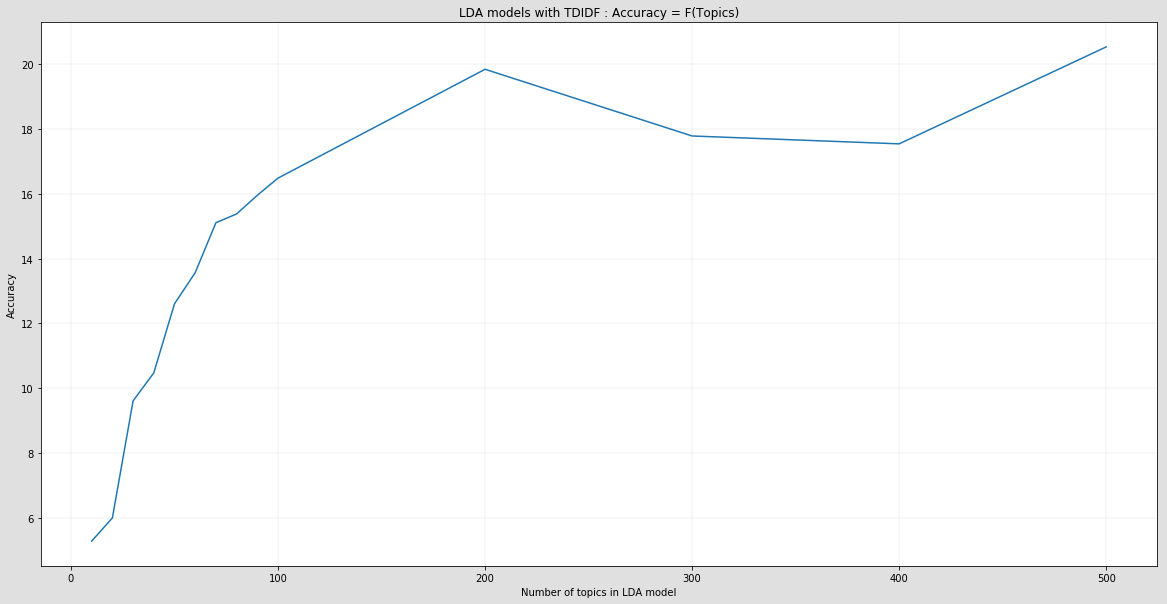

In [12]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)
if str(embedding_type) == 'bow' :
    dict_lda_mean_accuracy = dict_lda_bow_mean_accuracy.copy()
elif str(embedding_type) == 'tfidf' :
    dict_lda_mean_accuracy = dict_lda_tfidf_mean_accuracy.copy()
    
X = np.array([key for key in dict_lda_mean_accuracy.keys()])
y = np.array([value for value in dict_lda_mean_accuracy.values()])
#X=np.log(X)


title = "LDA models with TDIDF : Accuracy = F(Topics)"
p_x_title = "Number of topics in LDA model"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

## <font color='blus'>3.4. LDA with BOW </font>

In [ ]:
import p5_util
file_name="./data/csr_matrix_bow.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

In [ ]:
import p5_util
file_name="./data/vectorizer_bow.dump"
vectorizer = p5_util.object_load(file_name)

In [ ]:
bow_feature_names = vectorizer.get_feature_names()

### <font color='blue'>3.4.1. Initializing a set of LDAs models depending of topics numbers</font>

In [ ]:
import p5_util
import p6_util
range_1_topic = range(10,110,10)

embedding_type = "bow"
file_name="./data/csr_matrix_bow.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)
p6_util.p6_lda_build_range(range_1_topic,embedding_type, csr_matrix, rangeName='range10to100')


In [ ]:
import p5_util
import p6_util
range_2_topic = range(100,600,100)
embedding_type = "bow"
file_name="./data/csr_matrix_bow.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)
p6_util.p6_lda_build_range(range_2_topic,embedding_type, csr_matrix)


### <font color='blue'>3.4.2. LDA performances evaluation with BOW</font>

In [ ]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

In [ ]:
import pandas as pd
file_name="./data/StackOverFlowTags.csv"
df_sof_tags=pd.read_csv(file_name)
df_sof_tags.shape

**<font color='blue'>Score computing for topics ranged from 10 to 100</font>**

In [ ]:
import p6_util

list_sof_tags = df_sof_tags.TagName.tolist()

dict_dict_score_lda=dict()
nb_test = 1000
embedding_type='bow'
p6_util.p6_lda_range_mean_score(nb_test, range_1_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer, rangeName='range10to100') 

**<font color='blue'>Score computing for topics ranged from 100 to 600</font>**

In [ ]:
import p6_util

list_sof_tags = df_sof_tags.TagName.tolist()

dict_dict_score_lda=dict()
nb_test = 1000
embedding_type='bow'
p6_util.p6_lda_range_mean_score(nb_test, range_2_topic, embedding_type, df_sof_test\
                        ,list_sof_tags, vectorizer) 

In [ ]:
import numpy as np

if str(embedding_type) == 'bow' :
    dict_lda_bow_mean_accuracy = dict()
elif str(embedding_type) == 'tfidf' :
    dict_lda_tfidf_mean_accuracy = dict()
else :
    print("\n*** ERROR : unknow embredding type = "+str(embedding_type))
    
for nb_topic in range_1_topic:
    fileName = "./data/dict_score_lda_"+str(embedding_type)+"_"+str(nb_topic)+'_'+'range10to100'+".dump"
    dict_score_lda = p5_util.object_load(fileName)
    
    sumScore=0.
    for key in dict_score_lda.keys():
        sumScore += dict_score_lda[key]
    lda_mean_accuracy = 100*sumScore/len(dict_score_lda)

    if str(embedding_type) == 'bow' :
        dict_lda_bow_mean_accuracy[nb_topic] = lda_mean_accuracy
    elif str(embedding_type) == 'tfidf' :
        dict_lda_tfidf_mean_accuracy[nb_topic] = lda_mean_accuracy

for nb_topic in range_2_topic:
    fileName = "./data/dict_score_lda_"+str(embedding_type)+"_"+str(nb_topic)+".dump"
    dict_score_lda = p5_util.object_load(fileName)
    
    sumScore=0.
    for key in dict_score_lda.keys():
        sumScore += dict_score_lda[key]
    lda_mean_accuracy = 100*sumScore/len(dict_score_lda)
    if str(embedding_type) == 'bow' :
        dict_lda_bow_mean_accuracy[nb_topic] = lda_mean_accuracy
    elif str(embedding_type) == 'tfidf' :
        dict_lda_tfidf_mean_accuracy[nb_topic] = lda_mean_accuracy
    
     

In [ ]:
import p6_util_plot
import numpy as np

item_count = None#len(dict_lda_mean_accuracy)
X = np.array([key for key in dict_lda_mean_accuracy.keys()])
y = np.array([value for value in dict_lda_mean_accuracy.values()])
#X=np.log(X)


title = "LDA models : Accuracy = F(Topics)"
p_x_title = "Number of topics in LDA model"
p_y_title = "Accuracy"
item_count=None
p6_util_plot.X_y_plot(X,y,item_count,title, p_x_title, p_y_title)

## 3.3. DBSCAN clustering

In [ ]:
import p5_util
file_name="./data/csr_matrix_bow.dump"
csr_matrix_bow = p5_util.object_load(file_name)
print(csr_matrix_bow.shape)

file_name="./data/vectorizer_bow.dump"
vectorizer_bow = p5_util.object_load(file_name)

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

p_eps=5
# ALL CPU are activated
dbscan = DBSCAN(eps=p_eps,min_samples=100, n_jobs=-1)


pred_dbscan =  dbscan.fit_predict(csr_matrix_bow.toarray())

np.unique(pred_dbscan)

In [ ]:
print("Noise : "+str(len(np.where(pred_dbscan==-1)[0])))
print("Classified : "+str(len(np.where(pred_dbscan!=-1)[0])))

CSR matrix is converted into dataframe in order to feed cluster algorithm

In [ ]:
import pandas as pd
df_sof = pd.DataFrame(csr_matrix.toarray())
print(df_sof.shape)

In [ ]:
import p5_util
cluster_start = 1
cluster_end = 10
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_sof, cluster_start, cluster_end)

**Save Kmeans clustering scan**

In [ ]:
import p5_util

fileName = './data/dict_tfidf_clustering_kmeans.dump'
p5_util.object_dump(dict_kmeans, fileName)

In [ ]:
import p5_util_plot
import p5_util
is_reloaded = False
if is_reloaded is True:
    fileName = './data/dict_tfidf_clustering_kmeans.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'Features : Nb. clusters'
x_label_1 = 'Features : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

In [ ]:
type(dict_kmeans[8])

## 3.3. Word2Vec model

### Embedding corpus with Word2vec model

It is expected that ``word2vec`` learns relationships between words automatically.

* ``df_sof_train['Body']`` represents the corpus with which ``word2vec`` model is feeded.
* Once feed, ``word2vec`` will build a vocabulary, mean, a list of words (features) from which any word from corpus is vectorized.
* Matrix [Corpus words x Features] is stored in ``word2vec_model.wv.vectors``.


In [ ]:
import p6_util
list_sentence = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')

In [ ]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(list_sentence, min_count=2, size=100, sg=1)

In [ ]:
print(len(word2vec_model.wv.vocab))
len(word2vec_model.wv.vectors)

In [ ]:
word2vec_model.save("word2vec_model")

## Test and performance

In [ ]:
import pandas as pd
file_name="./data/test_StackOverFlow_BodyTitleTags.csv"
df_sof_test=pd.read_csv(file_name)

### Word2Vec model

* A post is randomly selected from test dataset.
* Then post is ipre-processed in order to feed M.L. model.

In [ ]:
import random
import p6_util

i_random = random.choice(range(0, df_sof_test.shape[0]))
body= df_sof_test.Body.iloc[i_random]
title= df_sof_test.Title.iloc[i_random]
post = body+title
post=title

In [ ]:
post=title
df_post = p6_util.preprocess_post(post)

* Tag counts is computed from test.
* Computed tags are returned with same number and same format then tags from test.

In [ ]:
import p6_util
tag_count=p6_util.get_tag_count(df_sof_test.Tags.iloc[i_random])

list_computed_tag = p6_util.get_list_tag_from_post(df_post.Body.iloc[0], word2vec_model, max_tag=tag_count)
print("Computed tags = "+"".join(list_computed_tag))
print("")
print("Tags from test = "+df_sof_test.Tags.iloc[i_random])
print("------------------------------------------")
print("Posted question : \n")
print("Title : "+str(title))
print("")
print("Body: "+str(body))

## Plot 2D projection of Word2Vec embedded vocabulary

In [ ]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("word2vec_model")

len(word2vec_model.wv.vocab.keys()), len(word2vec_model.wv.vectors)

### Compute matrix for any word into corpus

**Load cleaned train-dataset**

In [ ]:
import p5_util
file_name='./data/df_sof_train.dump'
df_sof_train=p5_util.object_load(file_name)

**Get SOF corpus from dataframe**

In [ ]:
import p6_util
list_corpus = p6_util.get_list_sentence_from_df(df_sof_train, 'Body')

In [ ]:
list_tokenized_corpus=list()
i=0
for list_word in list_corpus:
    list_tokenized_corpus += list_word
    

In [ ]:
len(list_tokenized_corpus[1:]), len(list_tokenized_corpus)

### 2D t-SNE transformation

#### Load TDIF Matrix

In [ ]:
import p5_util
file_name="./data/csr_matrix_tdif.dump"
csr_matrix = p5_util.object_load(file_name)

print(csr_matrix.shape)

**Get sample from CSR matrix**

In [ ]:
import random
import numpy as np
arr = np.zeros(100)
array = csr_matrix.toarray()
#array_index_sample = random.sample(list(csr_matrix.shape), 10)

arr_index = np.random.randint(0,array.shape[0],1000)
array_sample = csr_matrix.toarray()[arr_index]

In [ ]:
array_sample.shape, array.shape

**Compute for embedded vocabulary t-SNE projection with different perplexity values**

In [ ]:
import p5_util
if True:
    #X_std=word2vec_model.wv.vectors
    X_std = array_sample
    my_list_tsne_perplexity=[var for var in range(5,55,5)]
    dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=1000, list_tsne_perplexity=my_list_tsne_perplexity)

**Plot points issued from t-SNE transformations for each perplexity value**

In [ ]:
import p5_util_plot
if True :
    nb_col = 4     
    p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result, nb_col, ratio=0.05)

**Compute vocabulary t-SNE transformation for a fixed perplexity value**

In [ ]:
import p5_util

X_std=word2vec_model.wv.vectors
print(X_std.shape)
perplexity=10
my_list_tsne_perplexity=[perplexity,]
dict_tsne_result = p5_util.tsne_2D_process_perplexity(X_std, tsne_iter=300, list_tsne_perplexity=my_list_tsne_perplexity)

In [ ]:
len(dict_tsne_result[perplexity]),X_std.shape

**Plot points issued from t-SNE embedded vocabulary transformation with words related to each point**

In [ ]:
import numpy as np
import p5_util_plot

nb_col = 1
dict_tsne_result_part={perplexity:dict_tsne_result[perplexity]}
p_annotation = np.array(list(word2vec_model.wv.vocab.keys()))
p5_util_plot.plot_2D_dict_tsne_result(dict_tsne_result_part, nb_col, ratio=0.05, annotation=p_annotation)

### 2D PCA transformation

In [ ]:
import pandas as pd
df_pca=pd.DataFrame(X_std)

In [ ]:
df_pca.shape

In [ ]:
import p3_util_plot
z__ = p3_util_plot.df_pca_all_plot(df_pca, plot=True)

In [ ]:
from sklearn.decomposition import PCA

nb_components=600
pca = PCA(n_components=nb_components)
pca.fit(X_std)
X_pca = pca.transform(X_std)
print(X_pca.shape)

**Save reduced PCA**

In [ ]:
import p5_util
file_name="./data/pca_600_tdif.dump"
p5_util.object_dump(X_pca, file_name)

In [ ]:
import p3_util_plot
p_ratio=0.1
title = str(int(p_ratio*100))+" % Embedded TF-IDF vocabulary"
pca_=p3_util_plot.df_pca_components_plot(df_pca, None, nb_components=2, param_title=title, ratio=p_ratio)

In [ ]:
df_pca.shape

In [ ]:
import pandas as pd

list(word2vec_model.wv.vocab.keys())
df_vocab=pd.DataFrame(list(word2vec_model.wv.vocab.keys()))

In [ ]:
df_vocab.shape

In [ ]:
import p3_util_plot

p3_util_plot.df_pcs2_plot(df_pca, pca_)